## Mini Project 02

In [30]:
import pandas as pd
import numpy as np
import datetime
import dateutil
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import MonthEnd
from pandas.tseries.offsets import DateOffset
from dateutil.relativedelta import relativedelta
import scipy
from scipy.optimize import minimize
import matplotlib.pyplot as plt


In [31]:
!pip install openpyxl

# Clean Bonds Data

1. Calculating Price as average of Ask/Bid price
2. Calculating Remaining years of maturity
3. Dropping treasuries maturing in odd months - maturing not in February, May, August, November. 
4. Adjusting dates with maturities with last date of Feb, May, Aug, Nov - to middle of the month date - just to correct for convention
5. Calculating accrued interest to adjust the dirty price (still not sure if the price listed is clean/dirty)

In [32]:
def adjust_to_mid_month(date):
    if date == (date + MonthEnd(0)):
        return date.replace(day=15)
    else:
        return date

In [33]:
bonds = pd.read_excel('bondsdata.xlsx')
bonds = bonds.drop(columns=['Issuer Name'])
bonds['Issue Date']= pd.to_datetime(bonds['Issue Date'])
bonds['Maturity'] = pd.to_datetime(bonds['Maturity'])
#average price
bonds['Mid Price'] = (bonds['Bid Price'] + bonds['Ask Price'])/2
valuation = datetime.date(2025,2,24)
bonds['Valuation'] = valuation
bonds['Valuation'] = pd.to_datetime(bonds['Valuation'])
#remaining maturity
bonds['Remaining'] = bonds['Maturity']-bonds['Valuation']
bonds['Remaining'] = bonds['Remaining'].dt.days/365
#actual maturity (or full tenure of the bond)
bonds['Actual'] = bonds['Maturity']-bonds['Issue Date']
bonds['Actual'] = bonds['Actual'].dt.days/365
bonds['FV'] = 100
bonds['Maturity Month'] = bonds['Maturity'].dt.month
arrbonds = [2,5,8,11]
arrnotes = [6,12]
#dropping bonds not maturing in standard months
bondspure = bonds[bonds['Maturity Month'].isin(arrbonds)==True]
bondspure['Maturity Date'] = bondspure['Maturity'].dt.day
#adjusting maturity dates
bondspure['Maturity_Adjusted'] = bondspure['Maturity'].apply(adjust_to_mid_month)
#calculating coupon
bondspure['Coupon'] = bondspure['Cpn']/100*bonds['FV']
bondspure['Coupon'] = bondspure['Coupon']/2
#dropping bonds that have already matured given the valuation date - i.e. not active bonds
bondspure = bondspure[bondspure['Maturity_Adjusted']>bondspure['Valuation']]

/var/folders/dz/50cxkjr943dgncn0g_w642kr0000gn/T/ipykernel_91614/3967870742.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bondspure['Maturity Date'] = bondspure['Maturity'].dt.day
/var/folders/dz/50cxkjr943dgncn0g_w642kr0000gn/T/ipykernel_91614/3967870742.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bondspure['Maturity_Adjusted'] = bondspure['Maturity'].apply(adjust_to_mid_month)
/var/folders/dz/50cxkjr943dgncn0g_w642kr0000gn/T/ipykernel_91614/3967870742.py:26: SettingWithCopyWarning: 
A valu

# Calculating Accrued Interest from last coupon

In [34]:
def get_last_coupon_date(maturity_date, valuation_date):
    coupon_date = maturity_date
    while coupon_date > valuation_date:
        coupon_date -= relativedelta(months=6)
    return coupon_date

In [35]:
bondspure['Last_Coupon_Date'] = bondspure.apply(
    lambda row: get_last_coupon_date(row['Maturity_Adjusted'], row['Valuation']),
    axis=1
)
#calculating the accrued interest as "(Held Period/Total period)*Coupon"
bondspure['Next_Last_Coupon_Date'] = bondspure['Last_Coupon_Date'] + DateOffset(months=6)
bondspure['Total Period Days'] = bondspure['Next_Last_Coupon_Date']-bondspure['Last_Coupon_Date']
bondspure['Total Period Days'] = bondspure['Total Period Days'].dt.days
bondspure['Held Period Days'] = bondspure['Valuation']-bondspure['Last_Coupon_Date']
bondspure['Held Period Days'] = bondspure['Held Period Days'].dt.days
bondspure['Accrued Interest'] = bondspure['Held Period Days']/bondspure['Total Period Days']
bondspure['Accrued Interest'] = bondspure['Accrued Interest']*bondspure['Coupon']
bondspure['Clean Price']  = bondspure['Mid Price']-bondspure['Accrued Interest']

In [36]:
bondspure

,Issue Date,Maturity,Bid Price,Ask Price,Cpn,Currency,Mid Price,Valuation,Remaining,Actual,...,Maturity Month,Maturity Date,Maturity_Adjusted,Coupon,Last_Coupon_Date,Next_Last_Coupon_Date,Total Period Days,Held Period Days,Accrued Interest,Clean Price
11,2015-05-15,2025-05-15,99.515625,99.582031,2.125,USD,99.548828,2025-02-24,0.219178,10.008219,...,5,15,2025-05-15,1.0625,2024-11-15,2025-05-15,181,101,0.592887,98.955941
12,2022-05-16,2025-05-15,99.656250,99.710938,2.750,USD,99.683594,2025-02-24,0.219178,3.000000,...,5,15,2025-05-15,1.3750,2024-11-15,2025-05-15,181,101,0.767265,98.916329
13,2018-05-31,2025-05-31,99.593750,99.664062,2.875,USD,99.628906,2025-02-24,0.263014,7.005479,...,5,31,2025-05-15,1.4375,2024-11-15,2025-05-15,181,101,0.802141,98.826765
14,2023-05-31,2025-05-31,99.960938,100.003906,4.250,USD,99.982422,2025-02-24,0.263014,2.002740,...,5,31,2025-05-15,2.1250,2024-11-15,2025-05-15,181,101,1.185773,98.796648
15,2020-06-01,2025-05-31,98.917969,99.007812,0.250,USD,98.962891,2025-02-24,0.263014,5.000000,...,5,31,2025-05-15,0.1250,2024-11-15,2025-05-15,181,101,0.069751,98.893139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,2024-02-15,2054-02-15,93.375000,93.421875,4.250,USD,93.398438,2025-02-24,28.994521,30.021918,...,2,15,2054-02-15,2.1250,2025-02-15,2025-08-15,181,9,0.105663,93.292775
343,2024-05-15,2054-05-15,99.437500,99.484375,4.625,USD,99.460938,2025-02-24,29.238356,30.019178,...,5,15,2054-05-15,2.3125,2024-11-15,2025-05-15,181,101,1.290401,98.170537
344,2024-08-15,2054-08-15,93.531250,93.578125,4.250,USD,93.554688,2025-02-24,29.490411,30.019178,...,8,15,2054-08-15,2.1250,2025-02-15,2025-08-15,181,9,0.105663,93.449025
345,2024-11-15,2054-11-15,97.625000,97.656250,4.500,USD,97.640625,2025-02-24,29.742466,30.019178,...,11,15,2054-11-15,2.2500,2024-11-15,2025-05-15,181,101,1.255525,96.385100


In [37]:
## Using only relevant columns in a new dataframe

In [41]:
bondsclean = bondspure[['Issue Date','Maturity_Adjusted','Valuation','Mid Price','Clean Price','FV',
                        'Actual','Remaining','Cpn','Coupon']]

In [42]:
bondsclean

,Issue Date,Maturity_Adjusted,Valuation,Mid Price,Clean Price,FV,Actual,Remaining,Cpn,Coupon
11,2015-05-15,2025-05-15,2025-02-24,99.548828,98.955941,100,10.008219,0.219178,2.125,1.0625
12,2022-05-16,2025-05-15,2025-02-24,99.683594,98.916329,100,3.000000,0.219178,2.750,1.3750
13,2018-05-31,2025-05-15,2025-02-24,99.628906,98.826765,100,7.005479,0.263014,2.875,1.4375
14,2023-05-31,2025-05-15,2025-02-24,99.982422,98.796648,100,2.002740,0.263014,4.250,2.1250
15,2020-06-01,2025-05-15,2025-02-24,98.962891,98.893139,100,5.000000,0.263014,0.250,0.1250
...,...,...,...,...,...,...,...,...,...,...
342,2024-02-15,2054-02-15,2025-02-24,93.398438,93.292775,100,30.021918,28.994521,4.250,2.1250
343,2024-05-15,2054-05-15,2025-02-24,99.460938,98.170537,100,30.019178,29.238356,4.625,2.3125
344,2024-08-15,2054-08-15,2025-02-24,93.554688,93.449025,100,30.019178,29.490411,4.250,2.1250
345,2024-11-15,2054-11-15,2025-02-24,97.640625,96.385100,100,30.019178,29.742466,4.500,2.2500


# Calculating cashflow and cashflow times schedules

In [43]:
def get_cashflows(coupon_rate, maturity_date, valuation_date, face_value=100):
    coupon_payment = (coupon_rate / 100 / 2) * face_value
    coupon_date = maturity_date
    coupon_dates = []
    while coupon_date > valuation_date:
        coupon_dates.append(coupon_date)
        coupon_date -= relativedelta(months=6)
    coupon_dates = coupon_dates[::-1]
    coupon_times = []

    for date in coupon_dates:
        diff = date-valuation_date
        days = diff.days
        coupon_times.append(days/365)

    cf = []
    for dt in coupon_dates[:-1]:
        cf.append(coupon_payment)

    cf.append(coupon_payment + face_value)
    
    return cf


In [44]:
def get_times(maturity_date, valuation_date):

    coupon_date = maturity_date
    coupon_dates = []

    while coupon_date > valuation_date:
        coupon_dates.append(coupon_date)
        coupon_date -= relativedelta(months=6)

    coupon_dates = coupon_dates[::-1]
    coupon_times = []

    for date in coupon_dates:
        diff = date-valuation_date
        days = diff.days
        coupon_times.append(days/365)

    return coupon_times

In [45]:
bondsclean['CF_Schedule'] = bondsclean.apply(
    lambda row: get_cashflows(row['Cpn'],row['Maturity_Adjusted'], row['Valuation'],row['FV']),
    axis=1
)

/var/folders/dz/50cxkjr943dgncn0g_w642kr0000gn/T/ipykernel_91614/542337430.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bondsclean['CF_Schedule'] = bondsclean.apply(


In [47]:
bondsclean['CF_times'] = bondsclean.apply(
    lambda row: get_times(row['Maturity_Adjusted'], row['Valuation']),
    axis=1
)

/var/folders/dz/50cxkjr943dgncn0g_w642kr0000gn/T/ipykernel_91614/3408738804.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bondsclean['CF_times'] = bondsclean.apply(


In [48]:
#filtering out super low maturity bonds

bondsfilter1 = bondsclean[bondsclean['Remaining']>0.5]

# Nelson Siegel Bootstrapping

1. Using all cashflows/all maturities to optimize parameters in the nelson siegel equation. 
2. Choosing to bound long-term level (beta0) at 0 (assuming it is not negative) and 4.5% for a long term level assumption
3. Slope/Curvature bounds are a broader range
4. Decay is capped at 1.5
5. Using scipy's minimize to bring squared error of actual price and model price

In [53]:
all_cashflows = bondsclean['CF_Schedule'].tolist()
all_times = bondsclean['CF_times'].tolist()
actual_prices = bondsclean['Mid Price'].tolist() #still unsure which of the prices is "clean"

In [54]:
len(actual_prices) #modeling on 201 prices

209

In [55]:
def nelson_siegel(t, beta0, beta1, beta2, lambd):
    t = np.array(t)
    term1 = (1 - np.exp(-lambd * t)) / (lambd * t)
    term2 = term1 - np.exp(-lambd * t)
    return beta0 + beta1 * term1 + beta2 * term2

def discount_factor(t, beta0, beta1, beta2, lambd):
    r = nelson_siegel(t, beta0, beta1, beta2, lambd)
    return np.exp(-r * t)

In [56]:
def price_bond(cashflows, times, beta0, beta1, beta2, lambd):
    dfs = discount_factor(times, beta0, beta1, beta2, lambd)
    return np.sum(cashflows * dfs)

In [57]:
def objective(params, all_cashflows, all_times, actual_prices):
    beta0, beta1, beta2, lambd = params
    total_error = 0
    for cfs, ts, actual_price in zip(all_cashflows, all_times, actual_prices):
        model_price = price_bond(cfs, ts, beta0, beta1, beta2, lambd)
        total_error += (actual_price - model_price) ** 2
    return total_error

In [86]:
initial_guess = [0.04, -0.02, 0.01, 1.0]
bounds = [(0,0.045), (-0.2, 0.2), (-0.2, 0.2), (0.01,2)]

result = minimize(objective, initial_guess, args=(all_cashflows, all_times, actual_prices), bounds=bounds)
beta0, beta1, beta2, lambd = result.x
print("Optimized NS parameters:", result.x)

Optimized NS parameters: [0.         0.04053098 0.08286973 0.02839736]


Plotting the yield curve

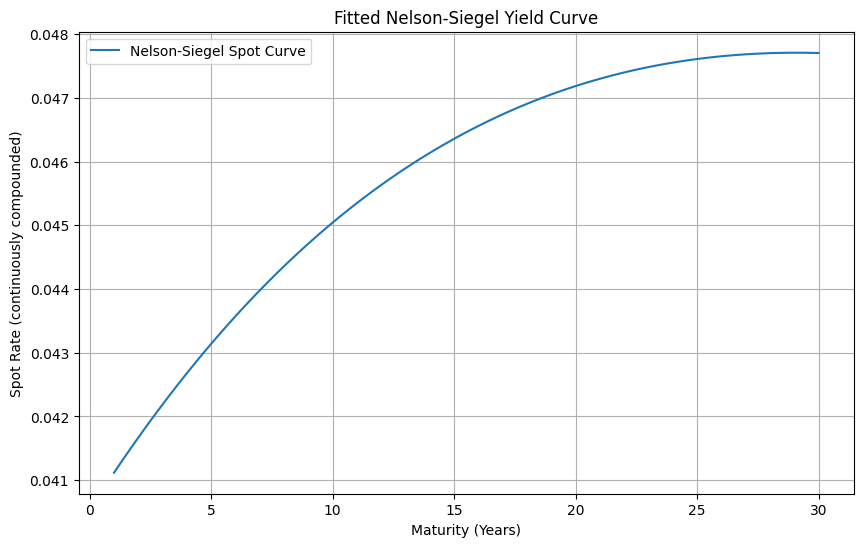

In [87]:
t_range = np.linspace(1, 30, 100)
yields = nelson_siegel(t_range, beta0, beta1, beta2, lambd)

plt.figure(figsize=(10, 6))
plt.plot(t_range, yields, label='Nelson-Siegel Spot Curve')
plt.xlabel("Maturity (Years)")
plt.ylabel("Spot Rate (continuously compounded)")
plt.title("Fitted Nelson-Siegel Yield Curve")
plt.grid(True)
plt.legend()
plt.show()


In [88]:
model_actual_df = pd.DataFrame()
model_actual_df['Actual Price'] = actual_prices
model_price = []
for i in range(len(actual_prices)):
    price = price_bond(all_cashflows[i],all_times[i],beta0,beta1,beta2,lambd)
    model_price.append(price)
model_actual_df['Model Price'] = model_price
model_actual_df['Difference'] = model_actual_df['Actual Price'] - model_actual_df['Model Price']
model_actual_df['Difference'] = model_actual_df['Difference']**2

In [89]:
model_actual_df

,Actual Price,Model Price,Difference
0,99.548828,100.165812,0.380669
1,99.683594,100.475539,0.627178
2,99.628906,100.537485,0.825515
3,99.982422,101.218885,1.528841
4,98.962891,99.236630,0.074933
...,...,...,...
204,93.398438,92.211433,1.408980
205,99.460938,99.288496,0.029736
206,93.554688,92.146145,1.983991
207,97.640625,97.231912,0.167047


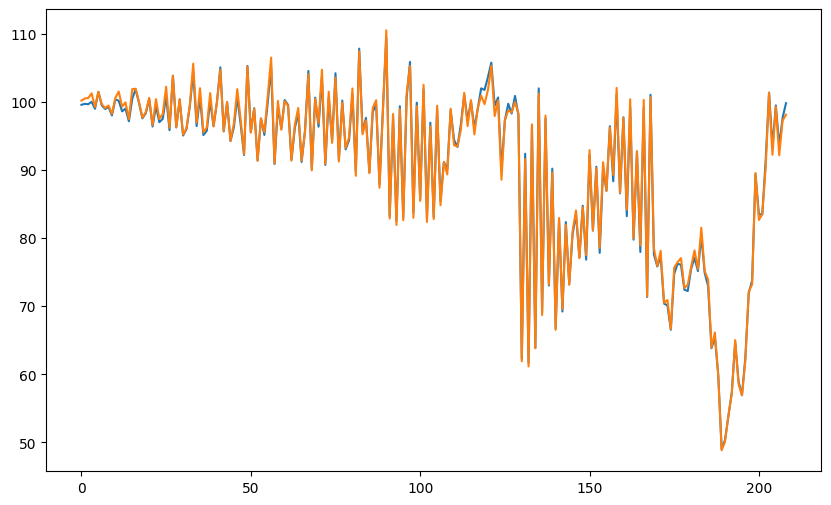

In [90]:
plt.figure(figsize=(10, 6))
plt.plot(model_actual_df['Actual Price'], marker='')
plt.plot(model_actual_df['Model Price'], marker='')

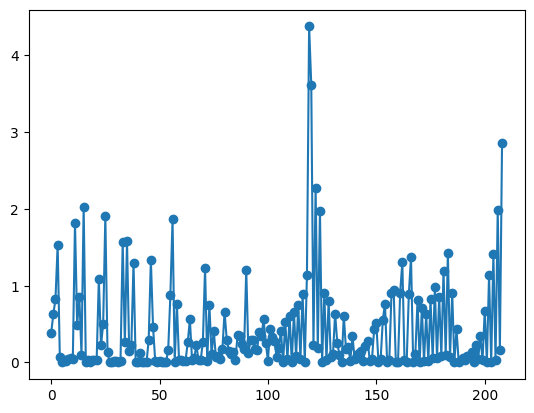

In [91]:
plt.plot(model_actual_df['Difference'],marker='o')

In [73]:
# trying to plot spot curve from the day that day

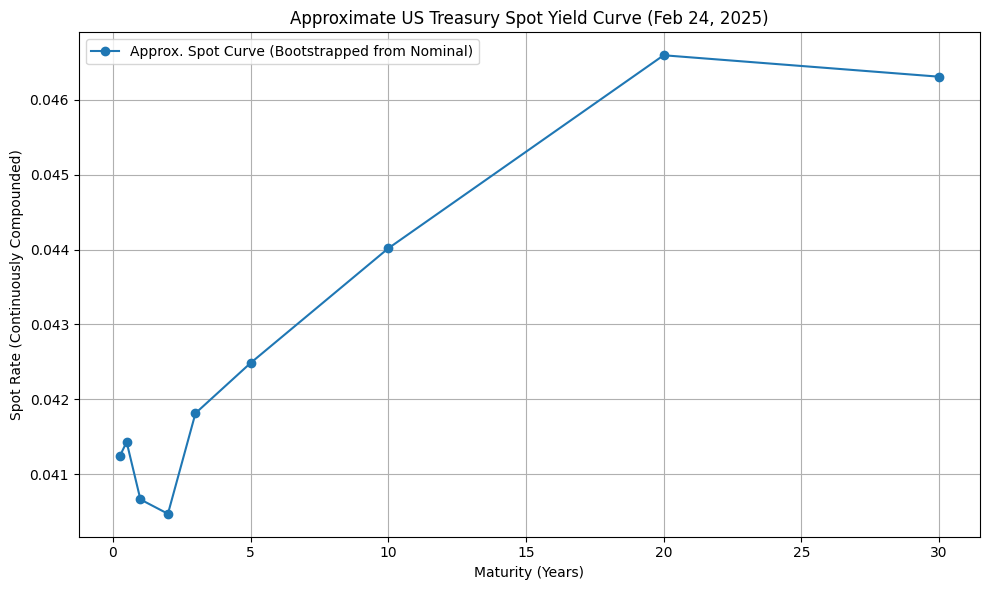

In [124]:
import numpy as np
import matplotlib.pyplot as plt

# Approximate nominal yields from US Treasury data (Feb 24, 2025)
maturities_years = np.array([0.25, 0.5, 1, 2, 3, 5, 10, 20, 30])
yields_nominal = np.array([0.0421, 0.0423, 0.0415, 0.0413, 0.0427, 0.0434, 0.0450, 0.0477, 0.0474])

# Convert nominal annual yields to continuously compounded spot rates
# r_cont = ln(1 + r_nominal)
spot_rates = np.log(1 + yields_nominal)

# Plot the spot yield curve
plt.figure(figsize=(10, 6))
plt.plot(maturities_years, spot_rates, marker='o', label='Approx. Spot Curve (Bootstrapped from Nominal)')
plt.title('Approximate US Treasury Spot Yield Curve (Feb 24, 2025)')
plt.xlabel('Maturity (Years)')
plt.ylabel('Spot Rate (Continuously Compounded)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


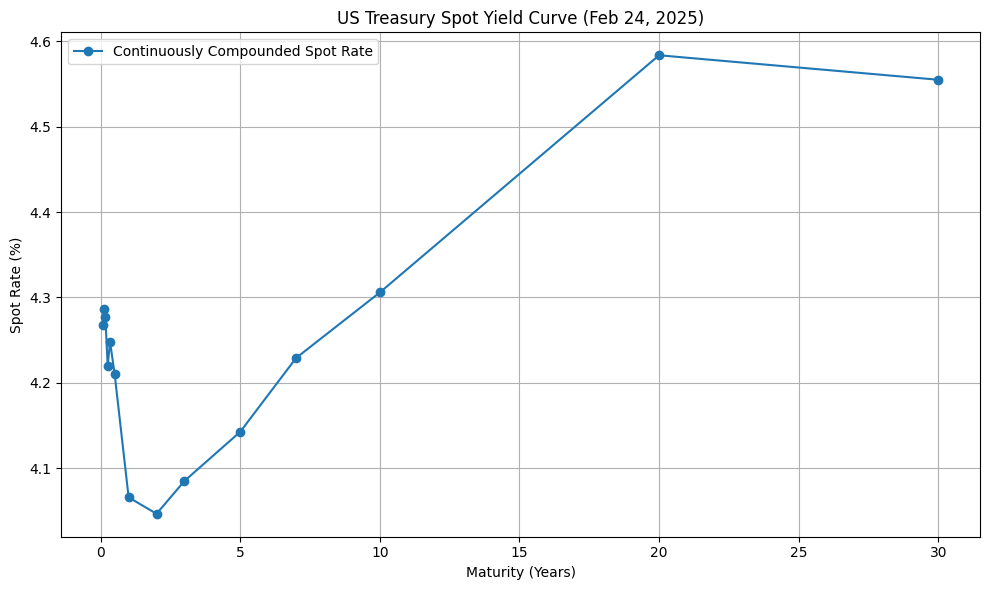

In [147]:
import numpy as np
import matplotlib.pyplot as plt

# Maturities in months and converted to years
maturities_months = [1, 1.5, 2, 3, 4, 6, 12, 24, 36, 60, 84, 120, 240, 360]
maturities_years = np.array(maturities_months) / 12

# Nominal annual yields (% converted to decimals)
nominal_yields = np.array([
    4.36, 4.38, 4.37, 4.31, 4.34, 4.30, 4.15, 4.13, 4.17,
    4.23, 4.32, 4.40, 4.69, 4.66
]) / 100

# Compute continuously compounded spot rates
spot_rates = np.log(1 + nominal_yields)

# Plot the yield curve
plt.figure(figsize=(10, 6))
plt.plot(maturities_years, spot_rates * 100, marker='o', label='Continuously Compounded Spot Rate')
plt.title('US Treasury Spot Yield Curve (Feb 24, 2025)')
plt.xlabel('Maturity (Years)')
plt.ylabel('Spot Rate (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
